In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import math
plt.rcParams["figure.figsize"] = [20,10]

In [2]:
import os 
os.getcwd()

'/Users/piruzalemi/Desktop'

In [3]:
import itertools 
#_OPTIONS_BASE_URL = "https://query1.finance.yahoo.com/" "v7/finance/options/{sym}"

In [4]:
days = 5
path_matrix=list(itertools.product([1,-1],repeat = days))


In [5]:
#for path in path_matrix:
#        print(path)
#        print(path[2])

In [6]:
# Specific areas of this program that are enhancements to the original R. Cox & Rubenstein Model has been supressed
# as they form the proprietory information of its authors & contributors that is not for public disemmination
#                                                                                   Piruz Alemi Dec 9th, 2019
class Node():
    #  ------------------------------------------------------------------------------------------
    #  Node simulates a tree of Nodes,
    #  that can move up or down
    #  How the Node moves also affects its internal(self) values
    #  https://www.macrotrends.net/2577/sp-500-pe-ratio-price-to-earnings-chart 
    #  ------------------------------------------------------------------------------------------
    
    def __init__(self, x=0,y=1,level=0):
        # Each node has an (x,y) position and contains a stock Value.
        self.x = x
        self.y = y
        self.level=0
        self.stockValue=312
        self.strikePrice=314
        
    def setup_parameters(self,rfr=0.03,vix_sigma=0.12,dt=.0197):
        self.sigma=vix_sigma
        self.r=rfr
        self.dt=dt
        # See equation 10.11 in Hull. The stock price either moves up by u or down by d proportions
        # where u/d = 1. This proprtionality is made an Exp function of volatility of stock sigma & time.
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        #self.u = 0.5
        self.d = 1./self.u
        # See equation 10.9 in Hull. To match the expected return on Stock u, with the trees parameters...
        # Probability of Node going up = qu and going down = qd
        self.qu = ((math.exp((self.r * self.dt))-self.d))/(self.u-self.d)
        self.qd = 1-self.qu
             
    def move_up(self, y_up=1.1, level=+1, rfr=0.03, vix_sigma=0.12, dt=.0197):
        # ------------------------------------------------------------------------------------
        # 1. Increment the level-position of the Node, each time you move-up
        # 2. lower the probability of going up by qu * qu
        # 3. Move the node to the right, as to capture the trajectory of the node on a given path
        # -------------------------------------------------------------------------------------
        self.sigma = vix_sigma
        self.r = rfr
        self.dt = dt
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = ((math.exp((self.r * self.dt))-self.d))/(self.u-self.d)
        self.qu = self.qu * self.qu
        self.qd= 1-self.qu
        #---------------------------------------------------------------------------------------
        self.y = y_up * self.y
        self.level += level
        self.factor=y_up
        #self.stockValue = self.factor * self.stockValue
        self.stockValue = self.u * self.stockValue
        #self.qu=self.qu * self.qu
        self.optionValue=max(self.stockValue - self.strikePrice,0)
        self.x += 1
        
    def move_down(self, y_down=0.90,level=-1,rfr=0.03,vix_sigma=0.12,dt=.0197):
        # Increment the y-position of the Node.
        self.sigma=vix_sigma
        self.r=rfr
        self.dt=dt
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = ((math.exp((self.r * self.dt))-self.d))/(self.u-self.d)
        self.qd = 1-self.qu
        self.qd = self.qd * self.qd
        #-------------------------------------------------
        self.level += level
        self.y = y_down * self.y
        self.factor=y_down
        #self.stockValue = self.factor * self.stockValue
        self.stockValue = self.d * self.stockValue
        self.optionValue=max(self.stockValue - self.strikePrice,0)
        #self.qd=self.qd * self.qd
        self.x += 1
        
    def move_right(self):
        # Increment the x-position of the Node.
        self.x += 1
        
    def move_left(self):
        # Decrease the x-position of the Node.
        self.x += -1
        
    def move_node(self,time_position=0,ud_pos=0):
         self.x += time_position
         self.y += ud_pos
        
    def outputDetail(self):
        return [self.x,self.level,self.stockValue,self.optionValue,self.u,self.qd,self.qu]
    




In [7]:
# -----------------------------------------------------------------------------------
# Create a node object, and have it start to move up or down.
# This section was a test on node objects and their changing positional values
# I thank Illya Alshteyn @ Columbia University for introducing me to OOL. Dec 8th, 2019
# -----------------------------------------------------------------------------------
my_node = Node()
print("Initial Node position:", my_node.x, my_node.y, my_node.stockValue, my_node.strikePrice)

Initial Node position: 0 1 312 314


In [8]:
my_node.setup_parameters()
print("node altitude rising....:", my_node.y, my_node.stockValue, my_node.qu, my_node.qd)

node altitude rising....: 1 312 0.5133383406643018 0.48666165933569816


In [9]:
my_node.move_up()
print("node altitude rising....:", my_node.y, my_node.stockValue,"Probability of the up node: ", my_node.qu)
print("node level going up...............................", my_node.level)
my_node.move_up()
print("node altitude rising....:", my_node.y, my_node.stockValue)

node altitude rising....: 1.1 317.29945800049353 Probability of the up node:  0.26351625199597883
node level going up............................... 1
node altitude rising....: 1.2100000000000002 322.68892963912486


In [10]:


print("node level going up...............................", my_node.level)

#my_node.move_node(3,2)
#print("node jumping to position....:", my_node.x, my_node.y, my_node.stockValue)

my_node = Node()
my_node.move_down()
print("node altitude going down....:", my_node.y, my_node.stockValue)

node level going up............................... 2
node altitude going down....: 0.9 306.7890522518592


In [11]:
# ----------------------------------------------------------------------------------------------
# Instantiate my_node, and initialize arrays to store all the nodes + their corresponding paths
# ---------------------------------------------------------------------------------------------
my_nodes = []
my_node = Node()
x_axis = []
path=[]

In [12]:
my_node.move_up()
#my_node = Node()
print(my_node.u,my_node.d)

1.0169854423092741 0.9832982443969845


In [13]:
# -----------------------------------------------------------------------------------------------------------
# - A remarkable Python command: for time period = 3, provide all the possible combinations of values
# - This gives for the possible value of +1, -1 combinates 2^^3=8 possible combinations of up (+1)
# - and Down (-1) combinations
# - 
# - I thank Terry Huang for this matrix approach that is the shortest path to the solution. 
# -                                                                Piruz Alemi Dec 8th, 2019
# -------------------------------------------------------------------------------------------------------------
path_matrix = list(itertools.product([1, -1], repeat=days))
print(path_matrix)
print(path_matrix[0])

[(1, 1, 1, 1, 1), (1, 1, 1, 1, -1), (1, 1, 1, -1, 1), (1, 1, 1, -1, -1), (1, 1, -1, 1, 1), (1, 1, -1, 1, -1), (1, 1, -1, -1, 1), (1, 1, -1, -1, -1), (1, -1, 1, 1, 1), (1, -1, 1, 1, -1), (1, -1, 1, -1, 1), (1, -1, 1, -1, -1), (1, -1, -1, 1, 1), (1, -1, -1, 1, -1), (1, -1, -1, -1, 1), (1, -1, -1, -1, -1), (-1, 1, 1, 1, 1), (-1, 1, 1, 1, -1), (-1, 1, 1, -1, 1), (-1, 1, 1, -1, -1), (-1, 1, -1, 1, 1), (-1, 1, -1, 1, -1), (-1, 1, -1, -1, 1), (-1, 1, -1, -1, -1), (-1, -1, 1, 1, 1), (-1, -1, 1, 1, -1), (-1, -1, 1, -1, 1), (-1, -1, 1, -1, -1), (-1, -1, -1, 1, 1), (-1, -1, -1, 1, -1), (-1, -1, -1, -1, 1), (-1, -1, -1, -1, -1)]
(1, 1, 1, 1, 1)


In [14]:
#------------------------------------------------------------------------------------------------
#-   This is the core for the construction of all the Nodes on the Tree, subject to the above path
#-   Current_ in path_materix is the element in Path Matrix. Its first element is like: (1,1,1)
#-   If period of the tree is 3., if 4, then (1,1,1,1), etc. So current- is the current path of nodes
#-   we are constructing
#----------------------------------------------------------------------------------------------------
Big_results =[]
#----------------------------------------------------------------------------------------------------
#-  Reminder! Must reset the Node to its initial position after completing/traversing each path
#-  If the node moves up/down, it also moves right! (which is now an attribute of the Node(object))
#----------------------------------------------------------------------------------------------------
for current_ in path_matrix:
    # Instantiate a Node
    my_node = Node()
    print('+++++++++++++++++++++')
    print(current_) # (1,1,1) or (1,1,-1), etc. is current
    print('Time,','Level,','Stock Price')
    #------------------------------------------------------------------------------------------------
    # Must reset the array of nodes that belonged to the path.
    # Note the same Object-Node was used through out the path
    # A new Node(object) is created solely for each path, whose attribute values change thru the path
    # For any path, a given node(object) moves thru time. However if we move to a different path we
    # must create a new object. This ensures we have a history of the each path.
    # Index in current captures the elements of say (1,1,-1), this tells us if the node goes up or down. 
    # for a given path... 
    # for a Trinomial tree, then we also consider if index = 0, and this section needs to be slightly modified
    #--------------------------------------------------------------------------------------------------
    my_nodes=[]
    for index in current_:
        if index > 0:
            my_node.move_up()
            #my_node.qu = my_node.qu * my_node.qu
            print(my_node.outputDetail())
            my_nodes.append(my_node.outputDetail())
        else:
            my_node.move_down()
            #my_node.qd = my_node.qd * my_node.qd
            print(my_node.outputDetail())
            my_nodes.append(my_node.outputDetail())
    Big_results.append(my_nodes)

+++++++++++++++++++++
(1, 1, 1, 1, 1)
Time, Level, Stock Price
[1, 1, 317.29945800049353, 3.29945800049353, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[2, 2, 322.68892963912486, 8.688929639124865, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[3, 3, 328.16994383735164, 14.169943837351639, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[4, 4, 333.7440554860387, 19.74405548603869, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[5, 5, 339.41284588656, 25.41284588655998, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
+++++++++++++++++++++
(1, 1, 1, 1, -1)
Time, Level, Stock Price
[1, 1, 317.29945800049353, 3.29945800049353, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[2, 2, 322.68892963912486, 8.688929639124865, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[3, 3, 328.16994383735164, 14.169943837351639, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]
[4, 4, 333.7440554860

In [15]:
#----------------------------------------------------------------------------
# Print all the elements of the Big_Matrix that now holds the values of Nodes
#----------------------------------------------------------------------------
for path in Big_results:
    print(path)
Big_results[0][0][2]

[[1, 1, 317.29945800049353, 3.29945800049353, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [2, 2, 322.68892963912486, 8.688929639124865, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [3, 3, 328.16994383735164, 14.169943837351639, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [4, 4, 333.7440554860387, 19.74405548603869, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [5, 5, 339.41284588656, 25.41284588655998, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883]]
[[1, 1, 317.29945800049353, 3.29945800049353, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [2, 2, 322.68892963912486, 8.688929639124865, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [3, 3, 328.16994383735164, 14.169943837351639, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [4, 4, 333.7440554860387, 19.74405548603869, 1.0169854423092741, 0.7364837480040212, 0.26351625199597883], [5, 3, 328.16994383735164, 14.1

317.29945800049353

In [16]:
x_axis = []
y_axis=[]
y_level=[]
node_level=[]
stockPrices =[]
optionValue=[]
stockU=[]
probQd=[]
probQu=[]

#---------------------------------------------------------------------------------------
#-  I thank Ju Chen for introducing the enumerate command, rather than my i,j,k indexing
#-                                                             Piruz Alemi Dec 8th, 2019
#---------------------------------------------------------------------------------------
# http://book.pythontips.com/en/latest/enumerate.html
#   for counter, value in enumerate(some_list):
#       print(counter, value)
#---------------------------------------------------------------------------------------
for day,path in enumerate(Big_results):
    for c_index,component in enumerate(path):
    #print(day, path)
    #print(c_index,component)
        x_axis.append(Big_results[day][c_index][0])
        node_level.append(Big_results[day][c_index][1])
        stockPrices.append(Big_results[day][c_index][2])
        optionValue.append(Big_results[day][c_index][3])
        stockU.append(Big_results[day][c_index][4])
        probQd.append(Big_results[day][c_index][5])
        probQu.append(Big_results[day][c_index][6])
#x_axis.append(Big_results[0][0][0])
#y_level.append(Big_results[0][0][1])
# print(type(Node))
#print(z.stockValue)
#print(my_nodes)
#print(x_axis)
print(stockPrices)

[317.29945800049353, 322.68892963912486, 328.16994383735164, 333.7440554860387, 339.41284588656, 317.29945800049353, 322.68892963912486, 328.16994383735164, 333.7440554860387, 328.16994383735164, 317.29945800049353, 322.68892963912486, 328.16994383735164, 322.68892963912486, 328.16994383735164, 317.29945800049353, 322.68892963912486, 328.16994383735164, 322.68892963912486, 317.29945800049353, 317.29945800049353, 322.68892963912486, 317.29945800049353, 322.68892963912486, 328.16994383735164, 317.29945800049353, 322.68892963912486, 317.29945800049353, 322.68892963912486, 317.29945800049353, 317.29945800049353, 322.68892963912486, 317.29945800049353, 312.0, 317.29945800049353, 317.29945800049353, 322.68892963912486, 317.29945800049353, 312.0, 306.7890522518592, 317.29945800049353, 312.0, 317.29945800049353, 322.68892963912486, 328.16994383735164, 317.29945800049353, 312.0, 317.29945800049353, 322.68892963912486, 317.29945800049353, 317.29945800049353, 312.0, 317.29945800049353, 312.0, 317

In [17]:
#------------------------------------------------------------------------------------------
#-    First loop is for time period i. For each period get its nodes, which is 2**i
#-----------------------------------------------------------------------------------------
#for i in range(0,5):
#    my_node.level= 0
#    height = 2**(i)
#    my_node.move_right()
#    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
#    print('height: ', height)
#    print('time:', my_node.x,'level: ', my_node.level, 'y: ', my_node.y, 'stockPrice: ', my_node.stockValue, my_node.strikePrice)
#---------------------------------------------------------------------------------------
#   Second Loop: Nodes are at different heights
#---------------------------------------------------------------------------------------
#    current_ = []
#    for h in range(0,height):
#        my_node.move_up()
#        my_nodes.append(my_node)
#        print('time:', my_node.x,'level: ', my_node.level, 'y: ', my_node.y, 'stockPrice: ', my_node.stockValue, my_node.strikePrice)
#        my_node.move_down()
#        my_nodes.append(my_node)
#        print('time:', my_node.x,'level: ', my_node.level, 'y: ', my_node.y, 'stockPrice: ', my_node.stockValue, my_node.strikePrice)
#        h=h+2
#        x_axis.append(my_node.x)
#        current_.append(my_node.outputDetail())
#        #print(my_nodes.move)
#        print('output detail>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>:')
#        print(my_node.outputDetail())
#    #my_nodes.append(current_)

        #x_axis
#my_nodes

In [18]:
#path_matrix = list(itertools.product([1, -1], repeat=3))
#print(path_matrix)

In [19]:
# create a data frame from Stock-Option Nodes
stockOption_dict = {
    "time": x_axis,
    'node_level': node_level,
    'stockPrices': stockPrices,
    'optionValue': optionValue,
    'stock u factor': stockU,
    'probability of node UP': probQu,
    'probability of node Down': probQd
}
stockOption_data = pd.DataFrame(stockOption_dict)
  
stockOption_data.head(20)


,time,node_level,stockPrices,optionValue,stock u factor,probability of node UP,probability of node Down
0,1,1,317.299458,3.299458,1.016985,0.263516,0.736484
1,2,2,322.688930,8.688930,1.016985,0.263516,0.736484
2,3,3,328.169944,14.169944,1.016985,0.263516,0.736484
3,4,4,333.744055,19.744055,1.016985,0.263516,0.736484
4,5,5,339.412846,25.412846,1.016985,0.263516,0.736484
5,1,1,317.299458,3.299458,1.016985,0.263516,0.736484
6,2,2,322.688930,8.688930,1.016985,0.263516,0.736484
7,3,3,328.169944,14.169944,1.016985,0.263516,0.736484
8,4,4,333.744055,19.744055,1.016985,0.263516,0.736484
9,5,3,328.169944,14.169944,1.016985,0.513338,0.236840


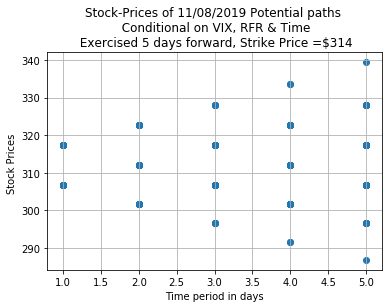

In [20]:
# Build a scatter plot for each data type
plt.scatter(stockOption_data["time"], stockOption_data["stockPrices"], marker="o", )

# Incorporate the other graph properties
plt.title("Stock-Prices of 11/08/2019 Potential paths \n  Conditional on VIX, RFR & Time \n Exercised 5 days forward, Strike Price =$314")
plt.ylabel("Stock Prices ")
plt.xlabel("Time period in days")

plt.grid(True)

# Save the figure
plt.savefig("alemi_stock_prices.png")
plt.show()
#plt.savefig("alemi_stock_prices.pdf")


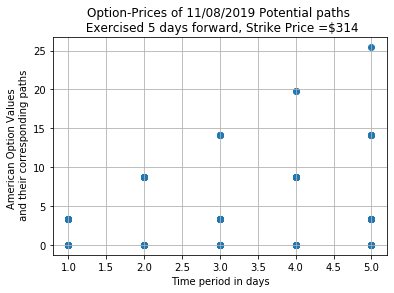

In [21]:
# Build a scatter plot for each data type
plt.scatter(stockOption_data["time"], stockOption_data["optionValue"], marker="o", )

# Incorporate the other graph properties
plt.title("Option-Prices of 11/08/2019 Potential paths \n Exercised 5 days forward, Strike Price =$314")
plt.ylabel("American Option Values \n and their corresponding paths")
plt.xlabel("Time period in days")

plt.grid(True)

# Save the figure
plt.savefig("alemi_option_prices.png")
#plt.savefig("alemi_option_prices.pdf")
plt.show()
#plt.savefig("alemi_option_prices.png")